<a href="https://www.kaggle.com/code/muhammadtayyabb/agriculture-pest-prediction?scriptVersionId=160012301" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

**Abstract:**
 The "Pest Prediction in Agriculture" project aims to leverage machine learning techniques to predict and manage pest infestations in agricultural fields. Pests can cause significant damage to crops, leading to reduced yields and economic losses. This project addresses this challenge by developing a predictive model that can forecast pest occurrences based on various environmental and crop-related factors. By identifying potential pest outbreaks in advance, farmers can implement targeted interventions, such as pesticide application or crop rotation, to mitigate the impact of pests and optimize crop production.


Before delving into the predictive prowess of our pest prediction model, ensure you follow the sequence of cells from start to finish, tapping into the full potential of a GPU accelerator for swift computations. It's worth noting that a simple user interface has been implemented, offering you the opportunity to test the model at your convenience. Moreover, your insights, feedback, and suggestions to elevate this notebook are not only welcomed but wholeheartedly cherished. Let's embark on this agricultural journey together, armed with innovation and collaboration. Here's to a thriving and resilient agricultural landscape ahead! Cheers!

**Import Librarires**

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import os
import tempfile


# Import visualization libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cv2
import seaborn as sns

# Tensorflow Libraries
from tensorflow import keras
from tensorflow.keras import layers,models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Resizing,Rescaling,InputLayer, Conv2D, BatchNormalization, MaxPool2D, Dropout, Flatten
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import EfficientNetB4
import tensorflow_probability as tfp
from tensorflow.keras import Model
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.regularizers import L2
from tensorflow.keras.metrics import CategoricalAccuracy, TopKCategoricalAccuracy
from tensorflow.keras.layers.experimental.preprocessing import RandomRotation, RandomFlip, RandomContrast



# System libraries
from pathlib import Path
import os.path

# Metrics
from sklearn.metrics import classification_report, confusion_matrix


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

**Data Loading**

In [2]:
data='/kaggle/input/agricultural-pests-image-dataset'
class_name=["ants",'bees','beetle','catterpillar','earthworms','earwig','grasshopper','moth','slug','snail','wasp','weevil']

In [3]:
configuration={'batchsize':32,'img_size':256,
               'learningrate':0.001,
               'n_epoches':12,
               "num_classes":12,
               'droupoutrate':0.0,
               'regularization_rate':0.0 ,
               'num_filters':6,
               "kernelsize":3,
               "n_strides":1,
               'poolsize':2,
               'N_DENSE_1':100,
               'N_DENSE_2':10,
}

In [4]:
def convert_path_to_df(dataset):
    image_dir = Path(dataset)

    # Get filepaths and labels
    filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.png')) + list(image_dir.glob(r'**/*.PNG'))

    labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

    filepaths = pd.Series(filepaths, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # Concatenate filepaths and labels
    image_df = pd.concat([filepaths, labels], axis=1)
    return image_df

image_df = convert_path_to_df(data)


In [5]:
train_df, test_df = train_test_split(image_df, test_size=0.2, shuffle=True, random_state=42)


In [6]:
def save_images_from_df(image_df, output_dir):
    for index, row in image_df.iterrows():
        filepath = row['Filepath']
        label = row['Label']
        
        image = cv2.imread(filepath)
        output_subdir = os.path.join(output_dir, label)
        os.makedirs(output_subdir, exist_ok=True)
        
        output_filepath = os.path.join(output_subdir, os.path.basename(filepath))
        cv2.imwrite(output_filepath, image)
        
# Provide the DataFrame and the output directory
train_data='train '
train_data = save_images_from_df(train_df, train_data)  # Change this to your desired output directory

test_directory = 'test'
save_images_from_df(test_df, test_directory )

In [7]:
train_data='/kaggle/working/train '

In [8]:
test_data='/kaggle/working/test'

In [9]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_data,
    labels='inferred',
    label_mode='categorical',
    class_names=class_name,
    color_mode='rgb',
    batch_size=configuration['batchsize'],
    image_size=(configuration['img_size'], configuration['img_size']),
    shuffle=True,
    seed=99,
    validation_split=0.2,  # Use 20% of the data for validation
    subset='training',     # Create a dataset for the training subset
)

val_dataset = tf.keras.utils.image_dataset_from_directory(
    train_data,
    labels='inferred',
    label_mode='categorical',
    class_names=class_name,
    color_mode='rgb',
    batch_size=configuration['batchsize'],
    image_size=(configuration['img_size'], configuration['img_size']),
    shuffle=True,
    seed=99,
    validation_split=0.15,  # Use 20% of the data for validation
    subset='validation',   # Create a dataset for the validation subset
)


Found 4395 files belonging to 12 classes.
Using 3516 files for training.
Found 4395 files belonging to 12 classes.
Using 659 files for validation.


In [10]:

test_dataset = tf.keras.utils.image_dataset_from_directory(
    test_data,
    labels='inferred',
    label_mode='categorical',
    class_names=class_name,
    color_mode='rgb',
    batch_size=configuration['batchsize'],
    image_size=(configuration['img_size'], configuration['img_size']),
    shuffle=True,
    seed=99,
)


Found 1099 files belonging to 12 classes.


# **Data Visualization**

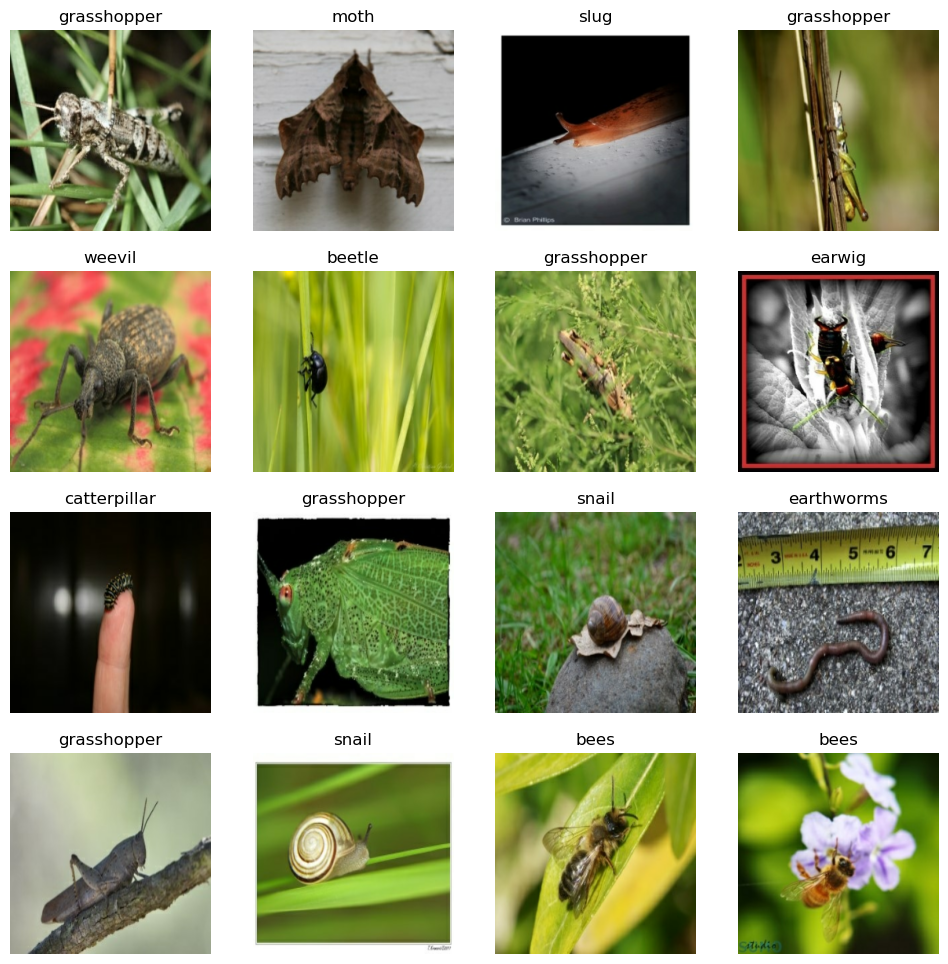

In [11]:
plt.figure(figsize=(12,12))
for   images,labels in  train_dataset.take(10):
  for i   in range(16):
   ax=plt.subplot(4,4,i+1)
   plt.imshow(images[i]/255.)
   plt.title(class_name[tf.argmax(labels[i],axis=0).numpy()])
   plt.axis("off")


In [12]:
vali_dataset=(
   val_dataset
    .prefetch(tf.data.AUTOTUNE)


)

In [13]:
resize_rescale=tf.keras.Sequential(
    Resizing(configuration['img_size'],configuration['img_size']),
    Rescaling(1./255)
)

## **MODEL**

In [14]:
pretrained_model = tf.keras.applications.efficientnet.EfficientNetB4(
    input_shape=(256, 256, 3),
    include_top=False,
    weights='imagenet',
    pooling='max'
)

pretrained_model.trainable = False

71686520/71686520 [==============================] - 0s 0us/step


In [15]:
lenet_model = tf.keras.Sequential([
    InputLayer(input_shape=(configuration["img_size"], configuration["img_size"], 3)),


   pretrained_model,
    BatchNormalization(),
    Dense(configuration["N_DENSE_1"], activation="relu",
          kernel_regularizer=L2(configuration['regularization_rate'])),
    BatchNormalization(),
      Dense(configuration["N_DENSE_2"], activation="relu",
          kernel_regularizer=L2(configuration['regularization_rate'])),
     BatchNormalization(),
      Dense(configuration["num_classes"], activation="softmax" )

])
lenet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb4 (Functional)  (None, 1792)             17673823  
                                                                 
 batch_normalization (BatchN  (None, 1792)             7168      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 100)               179300    
                                                                 
 batch_normalization_1 (Batc  (None, 100)              400       
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (None, 10)                1010      
                                                                 
 batch_normalization_2 (Batc  (None, 10)               4

### **loss**

In [16]:
loss_funcion=tf.keras.losses.CategoricalCrossentropy(
    from_logits=False,

)

In [17]:

metrics=[CategoricalAccuracy(name= 'accuracy'),TopKCategoricalAccuracy(k=2,name='top_k_accuracy')]

In [18]:
lenet_model.compile(
    optimizer=Adam(learning_rate=configuration['learningrate']),
                   loss=loss_funcion,
                   metrics=metrics

)

In [19]:
from functools import partial
from albumentations import (
    Compose, RandomBrightness, JpegCompression, HueSaturationValue, RandomContrast, HorizontalFlip,
    Rotate
)
AUTOTUNE = tf.data.experimental.AUTOTUNE

**Data Augmentation**

In [20]:
augment_layers = tf.keras.Sequential([
    RandomRotation(factor=(-0.25, 0.2501)),
   RandomFlip("horizontal_and_vertical",seed=42),  # Specify a seed for reproducibility
])


In [21]:
# Define a custom preprocessing function
def process_data(image, label):
    # Apply augmentation layers to the image
 # imag= tf.image.rgb_to_grayscale(image)

 # augmented_imag =  tf.image.random_contrast(
   #  imag, lower=0.1, upper=0.9, seed=42
  #)
  augmented_image=augment_layers(image)
    # Resize the augmented image
  resized_image = tf.image.resize(augmented_image, size=(configuration["img_size"], configuration["img_size"]))

  return resized_image, label

# Apply augmentation and preprocessing to the dataset
training_dataset = (
    train_dataset.
    shuffle(1000)
    .map(partial(process_data),num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)
    #.batch(configuration['batchsize'])
   # .prefetch(tf.data.AUTOTUNE)
)


**CUTMIX**

In [22]:
IM_SIZE=256
def box(lamda):
    r_x = tf.cast(tfp.distributions.Uniform(0, IM_SIZE).sample(1)[0], dtype=tf.int32)
    r_y = tf.cast(tfp.distributions.Uniform(8, IM_SIZE - 8).sample(1)[0], dtype=tf.int32)

    r_w = tf.cast(IM_SIZE * tf.math.sqrt(1 - lamda), dtype=tf.int32)
    r_h = tf.cast(IM_SIZE * tf.math.sqrt(1 - lamda), dtype=tf.int32)

    r_x = tf.clip_by_value(r_x, r_w // 2,configuration['img_size'] - r_w // 2)
    r_y = tf.clip_by_value(r_y, r_h // 2, configuration['img_size'] - r_h // 2)

    x_b_r = tf.clip_by_value(r_x + r_w // 2, 0, configuration['img_size'])
    y_b_r = tf.clip_by_value(r_y + r_h // 2, 0, configuration['img_size'])

    r_w = x_b_r - r_x
    if r_w == 0:
        r_w = 1

    r_h = y_b_r - r_y
    if r_h == 0:
        r_h = 1

    return r_y, r_x, r_h, r_w


In [23]:


def cutmix(train_dataset_1, train_dataset_2):
    (image_1, label_1), (image_2, label_2) = train_dataset_1, train_dataset_2

    lamda = tfp.distributions.Beta(0.2, 0.2)
    lamda_value = lamda.sample(1)[0]

    ry, rx, r_h, r_w = box(lamda_value)

    crop_2 = tf.image.crop_to_bounding_box(image_2, ry, rx, r_h, r_w)
    pad_2 = tf.image.pad_to_bounding_box(crop_2, ry, rx, configuration['img_size'] ,configuration['img_size'])

    crop_1 = tf.image.crop_to_bounding_box(image_1, ry, rx, r_h, r_w)
    pad_1 = tf.image.pad_to_bounding_box(crop_1, ry, rx, configuration['img_size'], configuration['img_size'])

    cutmixed_image = image_1 - pad_1 + pad_2


    lamda_value = tf.cast(1 - (r_w * r_h) / (configuration['img_size']*configuration['img_size']), dtype=tf.float32)

    cutmixed_label = lamda_value * tf.cast(label_1, dtype=tf.float32) + (1 - lamda_value) * tf.cast(label_2, dtype=tf.float32)

    return cutmixed_image, cutmixed_label


In [24]:
train_dataset_1 = train_dataset.map(process_data, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset_2 = train_dataset.map(process_data, num_parallel_calls=tf.data.AUTOTUNE)

mixed_dataset = tf.data.Dataset.zip((train_dataset_1, train_dataset_2))


In [25]:
cutmix_dataset = (
    mixed_dataset.
    shuffle(1000)
    .map(partial(cutmix),num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)
    #.batch(configuration['batchsize'])
)

In [26]:
print("GPU available:", tf.config.list_physical_devices('GPU'))


GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [27]:

history = lenet_model.fit(
        training_dataset,
            epochs=configuration['n_epoches'],
            verbose=1,
            validation_data=vali_dataset
        )




Epoch 1/12


2024-01-22 16:17:18.520785: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/efficientnetb4/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


110/110 [==============================] - 52s 270ms/step - loss: 1.2178 - accuracy: 0.7221 - top_k_accuracy: 0.8220 - val_loss: 0.6537 - val_accuracy: 0.8665 - val_top_k_accuracy: 0.9378
Epoch 2/12
110/110 [==============================] - 28s 222ms/step - loss: 0.7417 - accuracy: 0.8507 - top_k_accuracy: 0.9243 - val_loss: 0.4472 - val_accuracy: 0.9044 - val_top_k_accuracy: 0.9514
Epoch 3/12
110/110 [==============================] - 28s 226ms/step - loss: 0.5538 - accuracy: 0.8734 - top_k_accuracy: 0.9391 - val_loss: 0.3730 - val_accuracy: 0.9074 - val_top_k_accuracy: 0.9560
Epoch 4/12
110/110 [==============================] - 28s 231ms/step - loss: 0.4418 - accuracy: 0.8942 - top_k_accuracy: 0.9522 - val_loss: 0.3355 - val_accuracy: 0.9059 - val_top_k_accuracy: 0.9590
Epoch 5/12
110/110 [==============================] - 28s 228ms/step - loss: 0.3646 - accuracy: 0.9101 - top_k_accuracy: 0.9627 - val_loss: 0.3125 - val_accuracy: 0.9211 - val_top_k_accuracy: 0.9575
Epoch 6/12
110/1

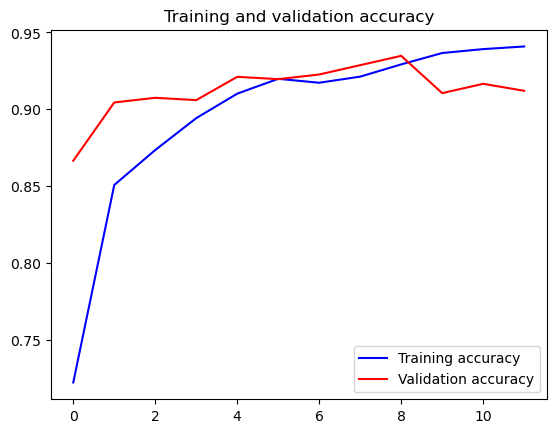

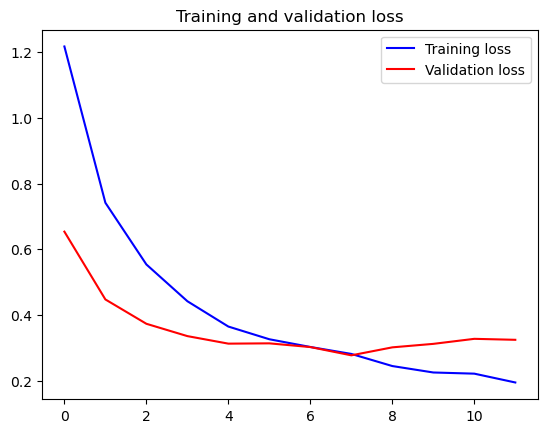

In [28]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')

plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')

plt.title('Training and validation loss')
plt.legend()
plt.show()

Prediction on Test Data

In [29]:
# Predict the label of the test_images
pred = lenet_model.predict(test_dataset)


35/35 [==============================] - 10s 203ms/step


In [30]:

lenet_model.evaluate(test_dataset)

35/35 [==============================] - 6s 179ms/step - loss: 0.3075 - accuracy: 0.9117 - top_k_accuracy: 0.9609


[0.3075442612171173, 0.9117379188537598, 0.960873544216156]

In [31]:
predicted=[]
labels=[]
for im, label in test_dataset:
    predicted.append(lenet_model(im))
    labels.append(label.numpy())

In [32]:
pred= np.concatenate([np.argmax(predicted[:-1],axis=-1).flatten(),np.argmax(predicted[-1],axis=-1).flatten()])
lab= np.concatenate([np.argmax(labels[:-1],axis=-1).flatten(),np.argmax(labels[-1],axis=-1).flatten()])

[[ 93   0   0   0   1   0   0   0   0   0   0   0]
 [  0  87   0   0   0   0   0   0   0   0   5   0]
 [  1   3  67   3   0   4   5   0   2   0   0   9]
 [  0   5   2  62   5   3   6   1   0   0   1   0]
 [  1   0   0   2  56   1   4   1   1   1   0   0]
 [  0   3   4   0   5  69   7   0   1   0   0   0]
 [  0   0   0   2   0   1 102   0   0   0   0   0]
 [  0   0   0   0   0   1   1  97   0   0   0   0]
 [  0   0   0   2   1   0   0   0  72   1   0   0]
 [  0   0   0   0   0   0   0   0   0 102   0   0]
 [  0   0   0   0   0   0   1   0   0   0 103   0]
 [  0   0   0   0   0   0   0   0   0   0   0  92]]


Text(0.5, 58.7222222222222, 'Predicted')

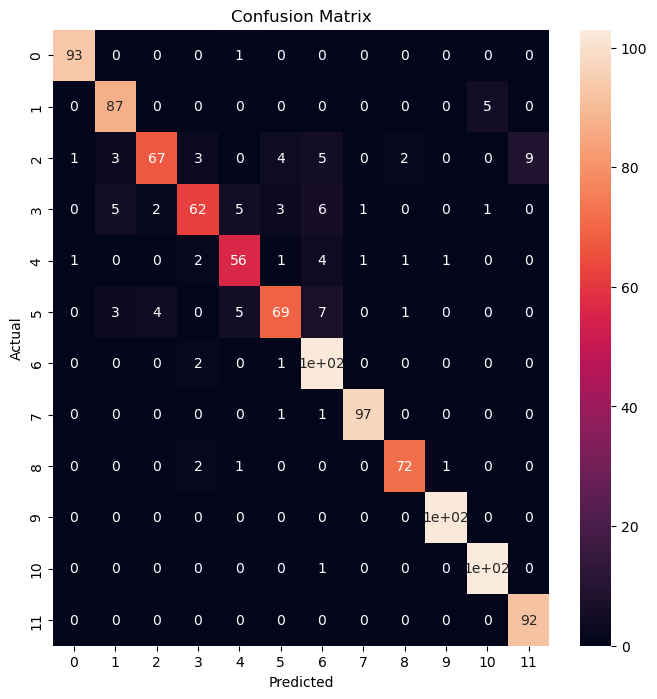

In [33]:
cm=confusion_matrix(lab,pred)
print(cm)
plt.figure(figsize=(8,8))
sns.heatmap(cm,annot=True)
plt.title("Confusion Matrix")
plt.ylabel('Actual')
plt.xlabel("Predicted")

**Visualizing**

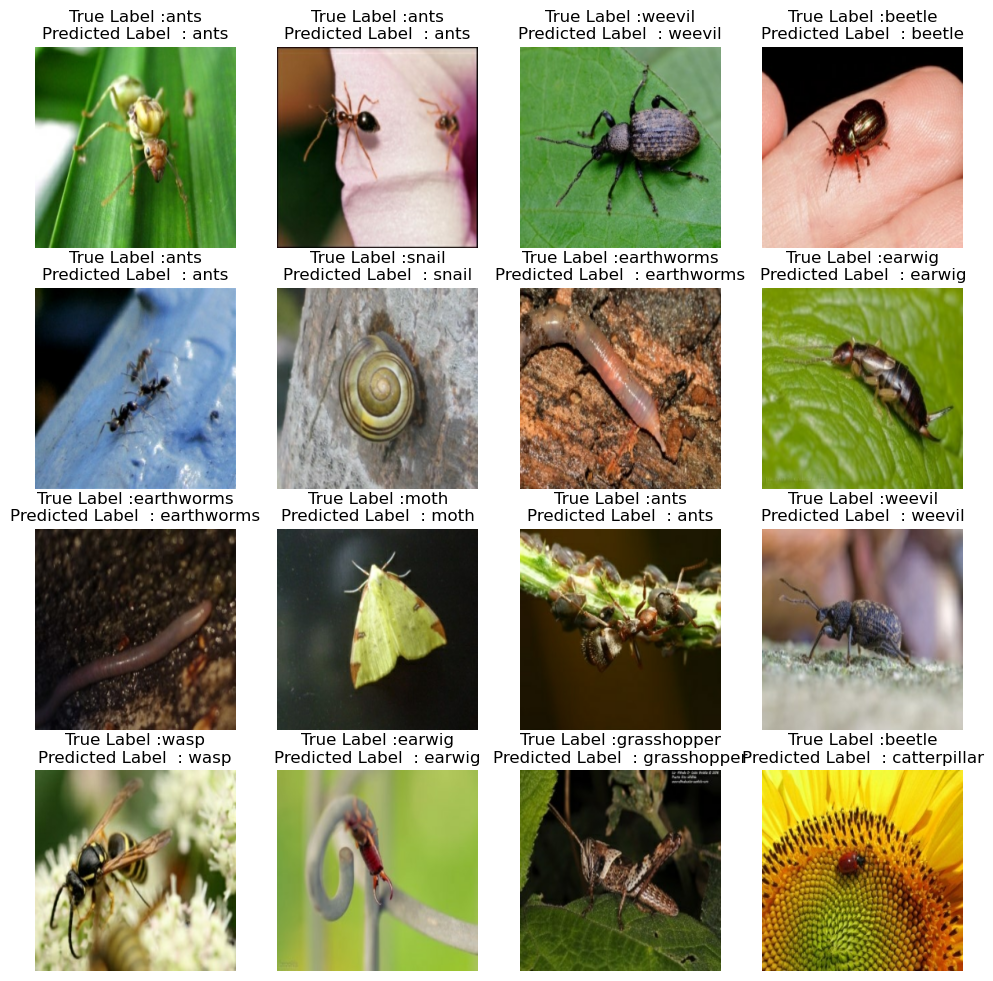

In [34]:
plt.figure(figsize=(12,12))
for   images,labels in  test_dataset.take(10):
  for i   in range(16):
   ax=plt.subplot(4,4,i+1)

   plt.imshow(images[i]/255.)
   plt.title("True Label :"+ class_name[tf.argmax(labels[i],axis=0).numpy()] + "\n" + "Predicted Label  : " + class_name[tf.argmax(lenet_model(tf.expand_dims(images[i],axis=0)),axis= -1).numpy()[0]])
   plt.axis("off")

In [35]:
from PIL import Image
def predicts(image_array):
      # Create a temporary directory
    temp_dir = tempfile.mkdtemp()

    # Define the file path for saving the image
    image_path = os.path.join(temp_dir, 'temp_image.jpg')  # Change the file format if needed

    # Save the image using OpenCV
    cv2.imwrite(image_path, image_array)
    test_img=Image.open(image_path)
    test_img=tf.image.resize(test_img, size=(configuration["img_size"], configuration["img_size"]))
    im=tf.constant(test_img,dtype=tf.float32)
    im=tf.expand_dims(im,axis=0)
    result=class_name[tf.argmax(lenet_model(im),axis= -1).numpy()[0]]
    return result.upper()

**UI**

In [36]:
! pip install gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 53.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - \ done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 305.2/305.2 kB 20.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.9/75.9 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 330.1/330.1 kB 24.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 381.9/381.9 kB 31.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 69.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 73.6 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of fastapi to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.1/71.1 kB 7.8 MB/s eta 0:00:00
     

In [37]:
import os

def count_images(directory_path, image_extensions=['.jpg', '.jpeg', '.png', '.gif', '.bmp']):
    
    image_count = 0

    # Validate directory path
    if not os.path.exists(directory_path) or not os.path.isdir(directory_path):
        print("Invalid directory path.")
        return 0

    # Iterate through files in the directory
    for filename in os.listdir(directory_path):
        file_path = os.path.join(directory_path, filename)

        # Check if the file is a regular file and has a valid image extension
        if os.path.isfile(file_path) and any(filename.lower().endswith(ext) for ext in image_extensions):
            image_count += 1

    return image_count

# Example usage:
directory_path = '/kaggle/working/test/ants'
total_images = count_images(directory_path)

print(f'Ants in field {total_images}')

directory_path = '/kaggle/working/test/moth'
total_images = count_images(directory_path)

print(f'Moth in field {total_images}')

directory_path = '/kaggle/working/test/beetle'
total_images = count_images(directory_path)

print(f'beetle in field {total_images}')

directory_path = '/kaggle/working/test/earwig'
total_images = count_images(directory_path)

print(f'Earwing in field {total_images}')

directory_path = '/kaggle/working/test/bees'
total_images = count_images(directory_path)

print(f'Bees in field {total_images}')

directory_path = '/kaggle/working/test/bees'
total_images = count_images(directory_path)

print(f'Bees in field {total_images}')

directory_path = '/kaggle/working/test/slug'
total_images = count_images(directory_path)

print(f'Slug in field {total_images}')

directory_path = '/kaggle/working/test/bees'
total_images = count_images(directory_path)

print(f'Bees in field {total_images}')

directory_path = '/kaggle/working/test/grasshopper'
total_images = count_images(directory_path)

print(f'Grosshopper in field {total_images}')

directory_path = '/kaggle/working/test/weevil'
total_images = count_images(directory_path)

print(f'Weevil in field {total_images}')

directory_path = '/kaggle/working/test/bees'
total_images = count_images(directory_path)

print(f'Bees in field {total_images}')

directory_path = '/kaggle/working/test/wasp'
total_images = count_images(directory_path)

print(f'Wasp in field {total_images}')

directory_path = '/kaggle/working/test/catterpillar'
total_images = count_images(directory_path)

print(f'Catterpillar in field {total_images}')

directory_path = '/kaggle/working/test/snail'
total_images = count_images(directory_path)

print(f'Snail in field {total_images}')

directory_path = '/kaggle/working/test/earthworms'
total_images = count_images(directory_path)

print(f'Earthworms in field {total_images}')






Ants in field 94
Moth in field 99
beetle in field 94
Earwing in field 89
Bees in field 92
Bees in field 92
Slug in field 76
Bees in field 92
Grosshopper in field 105
Weevil in field 92
Bees in field 92
Wasp in field 104
Catterpillar in field 85
Snail in field 102
Earthworms in field 67


**Thanks for viewing my work.**